In [1]:
# add questions and answers boxes?

In [56]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sc
import numpy.matlib
from scipy.stats import norm
from scipy.stats import t
import statsmodels.api as sm

## Preliminaries

Authored by *David J. Heeger*  1/26/2004<br>
Translated into Python by *Chrysa Papadaniil* 7/21 <br>

This tutorial demonstrates how to do basic fMRI data analysis in Python. In the process it provides lots of examples of Python code that you can use to build your own more sophisticated analysis tools. 

## Generating simulated fMRI data set

### Simulating an impulse of neural activity
Consider a vision experiment in which the stimulus display is blank (meangray) for the first 10 sec, then there is a brief (1 sec) presentation of a high contrast visual stimulus, followed once again by a blank screen for the remaining 39 sec. If we acquire data with TR=1 sec, then we could characterize the stimulus protocol with the following vector:

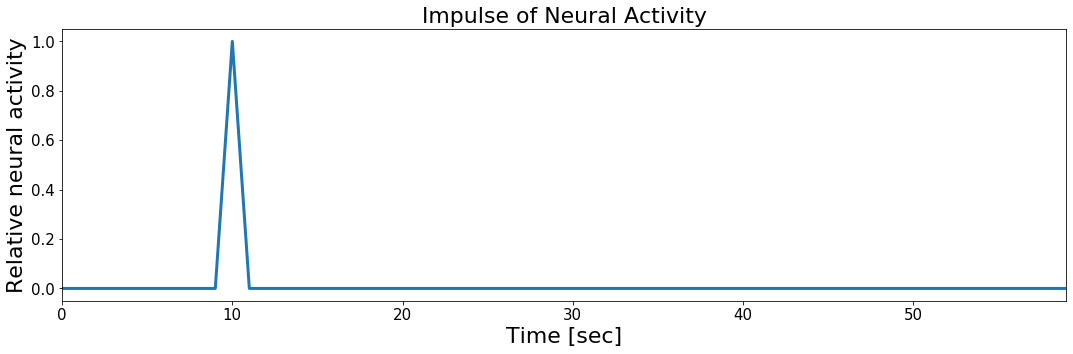

In [3]:
neural_activity = np.zeros(60)
neural_activity[10] = 1

# Plot it
plt.figure(figsize=(18,5))
plt.plot(neural_activity, lw=3)
plt.xlim([0, len(neural_activity)-1])
plt.xlabel('Time [sec]', fontsize=22)
plt.ylabel('Relative neural activity', fontsize=22)
plt.title('Impulse of Neural Activity', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()

### The hemodynamic impulse response

We can think of this as the time-course of the underlying neural activity. Because of the sluggish hemodynamic response, we would expect the fMRI response to be delayed and spread out over time. Formally, we use convolution to characterize the relationship between the fMRI response and the underlying neural activity. To simulate the effect of the hemodynamics, we use a model for the hemodynamic impulse response.

The gamma function is one of several popular approximations for the hemodynamic impulse response. There's nothing particularly special about the gamma function. There are other functions that do a better job of approximating the hemodynamics. But at least it is simple with only 2 free parameters:<br>
  - tau: time constant (sec)<br>
  - delta: pure delay after stimulus onset (sec)<br>

Choose some values for these parameters:

In [4]:
tau = 2
delta = 2

Now let's plot the HIRF with these parameter values (HIRF stands for "hemodynamic impulse response function"):

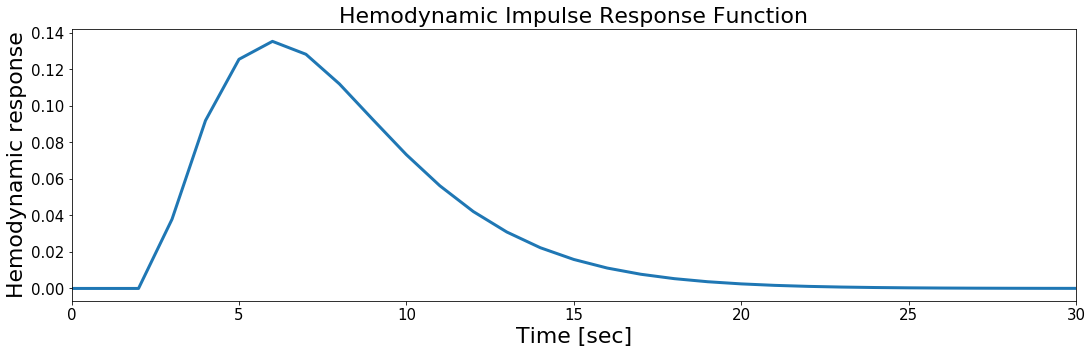

In [5]:
t = np.arange(0,31)
t_shift = np.maximum(t-delta,0)
HIRF = (t_shift/tau)**2 * np.exp(-t_shift/tau) / (2*tau)

# Plot it
plt.figure(figsize=(18,5))
plt.plot(HIRF, lw=3)
plt.xlim([0, len(HIRF)-1])
plt.xlabel('Time [sec]', fontsize=22)
plt.ylabel('Hemodynamic response', fontsize=22)
plt.title('Hemodynamic Impulse Response Function', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()

Change the values of tau and delta above parameters and replot the function to see what effect its parameter has on the shape of the function.

For every choice of parameters, the volume of the function is 1 (or very close to 1 - it would be exactly one if we sampled more finely than once per second):

In [6]:
sum(HIRF)

0.9996696420162915

### Computing the fMRI response from the neural activity and the hemodynamic impulse response

Now we use convolution to transform the neural_activity into an fmri signal:

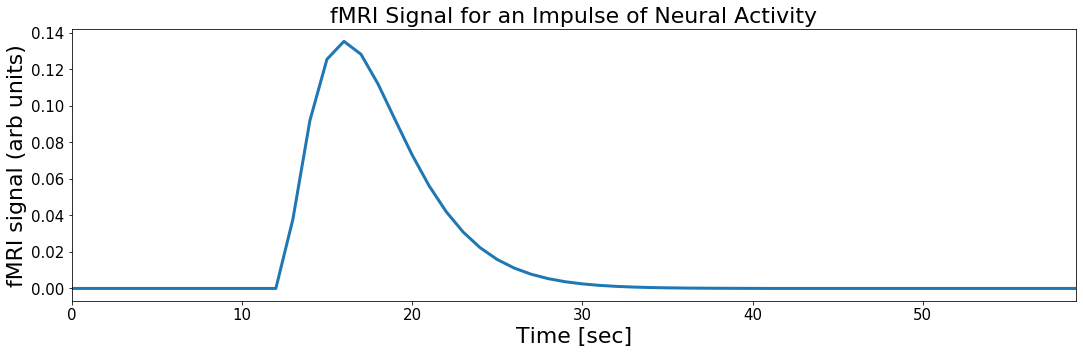

In [7]:
fmri_signal = np.convolve(neural_activity,HIRF)
fmri_signal = fmri_signal[:len(neural_activity)]

#Plot it
plt.figure(figsize=(18,5))
plt.plot(fmri_signal, lw=3)
plt.xlim([0, len(fmri_signal)-1])
plt.xlabel('Time [sec]', fontsize=22)
plt.ylabel('fMRI signal (arb units)', fontsize=22)
plt.title('fMRI Signal for an Impulse of Neural Activity', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()

The second line is needed because of the way in which numpy's convolve function works. If you type help(np.convolve) you can see the documentation for this function. Note that the length of the result is equal to the sum of the length of the two arrays minus 1. Because the output is longer then the input, we throw away the part of the fmri_signal that is padded at the end.

In [8]:
help(np.convolve)

Help on function convolve in module numpy:

convolve(a, v, mode='full')
    Returns the discrete, linear convolution of two one-dimensional sequences.
    
    The convolution operator is often seen in signal processing, where it
    models the effect of a linear time-invariant system on a signal [1]_.  In
    probability theory, the sum of two independent random variables is
    distributed according to the convolution of their individual
    distributions.
    
    If `v` is longer than `a`, the arrays are swapped before computation.
    
    Parameters
    ----------
    a : (N,) array_like
        First one-dimensional input array.
    v : (M,) array_like
        Second one-dimensional input array.
    mode : {'full', 'valid', 'same'}, optional
        'full':
          By default, mode is 'full'.  This returns the convolution
          at each point of overlap, with an output shape of (N+M-1,). At
          the end-points of the convolution, the signals do not overlap
          co

### Baseline

In real fMRI data, the change in image intensity over time is riding on top of a baseline image (see above, Loading and displaying MRI images). We typically plot the percent signal change in the image intensity. So let's add a value of 100 for the baseline or mean image intensity. And then divide by the mean and subtract 1 to convert to percent signal change. 

Note on terminology: I am using 'fmri_signal' to refer to the raw image intensity values and 'fmri_response' to refer to time series after they have been converted to units of percent signal change.

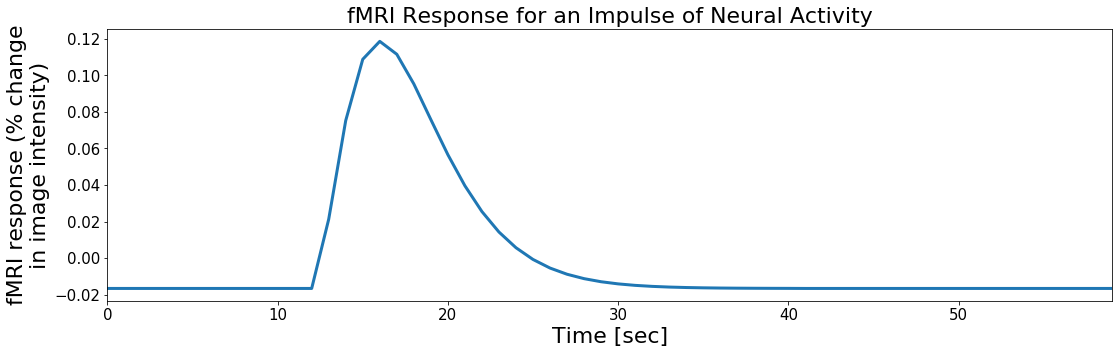

In [9]:
baseline = 100
    
fmri_signal = baseline + np.convolve(neural_activity,HIRF)
fmri_signal = fmri_signal[:len(neural_activity)]
fmri_response = 100 * ((fmri_signal/(np.mean(fmri_signal)) - 1))

#Plot it
plt.figure(figsize=(18,5))
plt.plot(fmri_response, lw=3)
plt.xlim([0, len(fmri_response)-1])
plt.xlabel('Time [sec]', fontsize=22)
plt.ylabel('fMRI response (% change\nin image intensity)', fontsize=22)
plt.title('fMRI Response for an Impulse of Neural Activity', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()

### Sustained response

See what happens to the fMRI response if we make the stimulus longer so that the neural activity is sustained for a longer period of time:

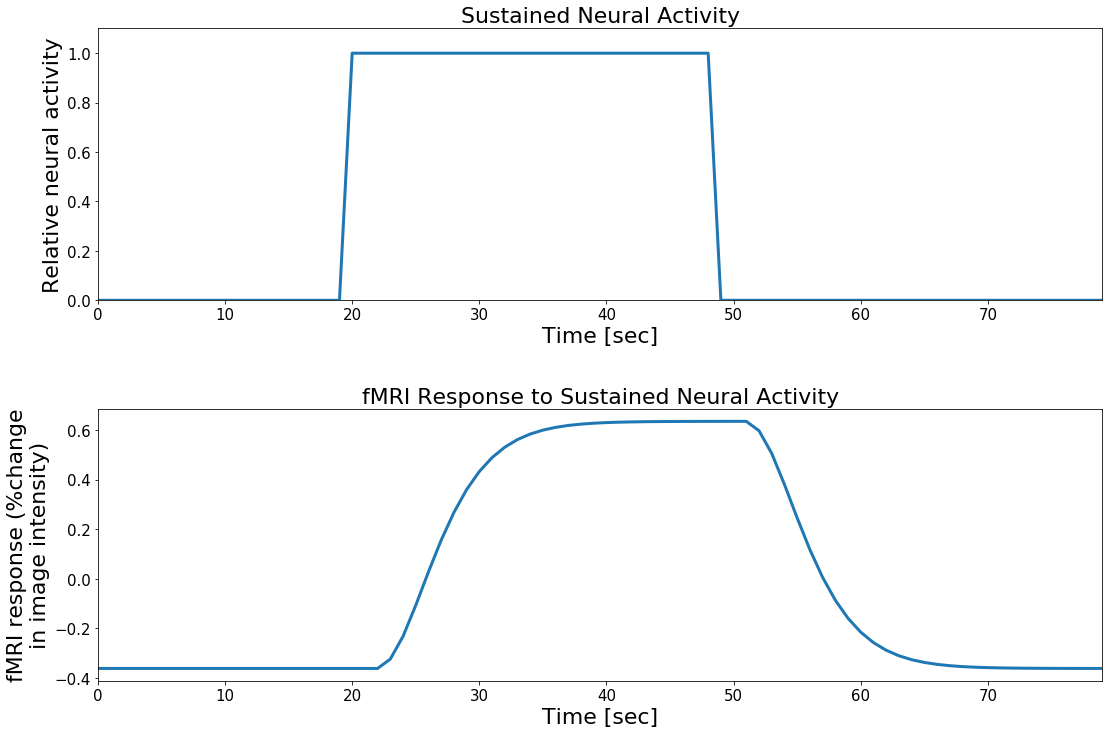

In [10]:
neural_activity = np.zeros(80)
neural_activity[20:49] = 1

fmri_signal = baseline + np.convolve(neural_activity,HIRF)
fmri_signal = fmri_signal[0:len(neural_activity)]
fmri_response = 100 * ((fmri_signal/(np.mean(fmri_signal)) - 1))

# Plot it
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[18,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(neural_activity, lw=3)
ax1.set_xlim([0, len(neural_activity)-1])
ax1.set_ylim([0, 1.1])
ax1.set_xlabel('Time [sec]', fontsize=22)
ax1.set_ylabel('Relative neural activity', fontsize=22)
ax1.set_title('Sustained Neural Activity', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(fmri_response, lw=3)
ax2.set_xlim([0, len(fmri_response)-1])
ax2.set_xlabel('Time [sec]', fontsize=22)
ax2.set_ylabel('fMRI response (%change\nin image intensity)', fontsize=22)
ax2.set_title('fMRI Response to Sustained Neural Activity', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

The peak-to-peak amplitude of the fMRI response was about 1% change in image intensity:

In [11]:
max(fmri_response)-min(fmri_response)

0.9960601169219263

### Block alternation

Now let's simulate the fMRI response for a block-alternation experiment in which the visual stimulus contrast (and hence the neural activity) changes from low to high every 6 seconds:

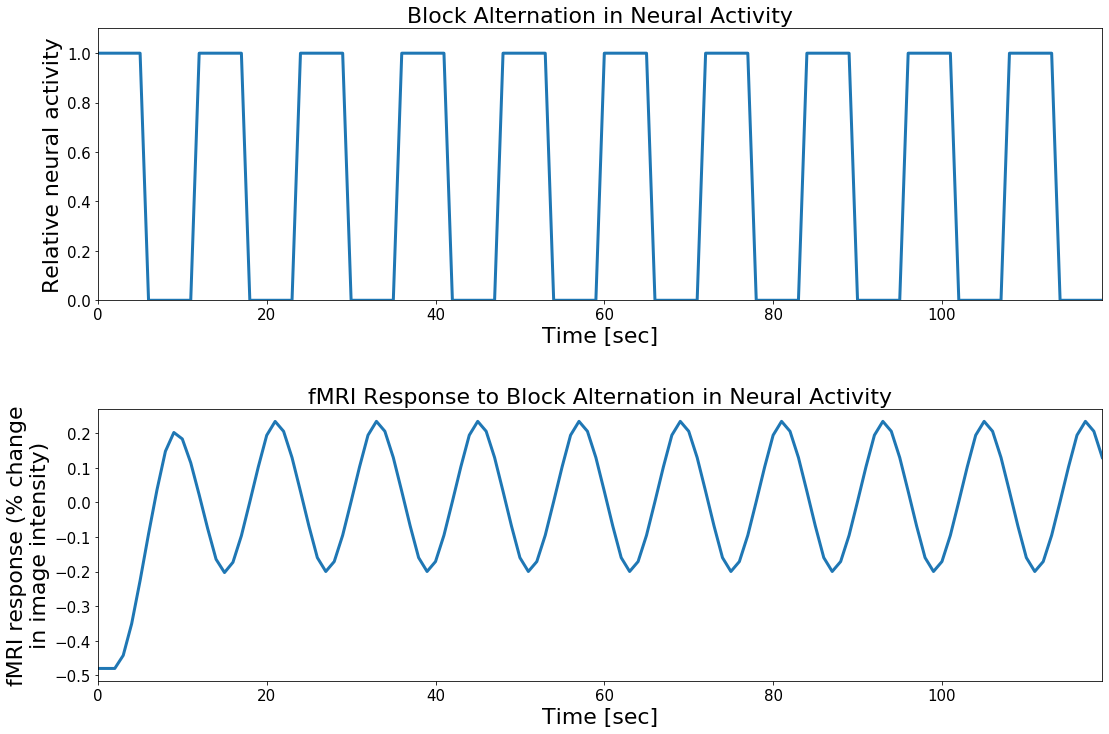

In [12]:
t = np.arange(0,120)
block_duration = 6
neural_activity = (t//block_duration + 1) % 2

fmri_signal = baseline + np.convolve(neural_activity,HIRF)
fmri_signal = fmri_signal[:len(neural_activity)]
fmri_response = 100 * ((fmri_signal/(np.mean(fmri_signal)) - 1))

# Plot it 
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[18,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(neural_activity, lw=3)
ax1.set_xlim([0, len(neural_activity)-1])
ax1.set_ylim([0, 1.1])
ax1.set_xlabel('Time [sec]', fontsize=22)
ax1.set_ylabel('Relative neural activity', fontsize=22)
ax1.set_title('Block Alternation in Neural Activity', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(fmri_response, lw=3)
ax2.set_xlim([0, len(fmri_response)-1])
ax2.set_xlabel('Time [sec]', fontsize=22)
ax2.set_ylabel('fMRI response (% change\nin image intensity)', fontsize=22)
ax2.set_title('fMRI Response to Block Alternation in Neural Activity', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

There are 10 cycles of neural activity and 10 cycles in the response. But that the fMRI response is delayed in time relative to the neural activity.

### The First Cycle

The first cycle of the response looks different. This is not an artifact of the simulation. It is really what one would expect to happen in a real fMRI data set because the brain is starting from an extended period with no stimulation before the first cycle, whereas there is a history of stimulation before each of the other cycles. Because the hemodynamics have such a long memory (20-30 sec or so), you have to deal with this transient that will occur at the beginning of each experiment. One way to deal with this transient in the hemodynamics is to try to explicitly take it into account in the analysis (which most analysis programs try to do). But, in fact, you have no idea what the subject was doing/thinking before the experiment began so there is no way to model it accurately. That's why in many labs, people typically toss the first chunk (20 sec or so) of the data to avoid the transient entirely.

By tossing the first 24 seconds, we get a nice periodic sinusoidal response:

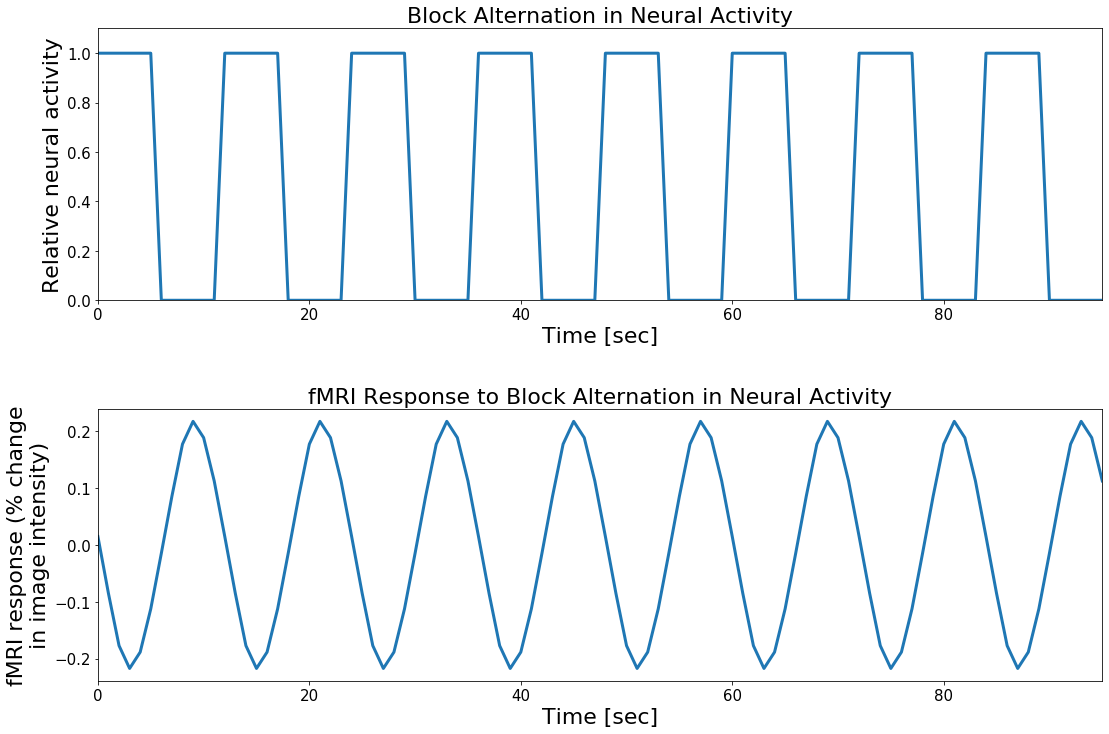

In [13]:
neural_activity = neural_activity[24:]
fmri_signal = fmri_signal[24:]
fmri_response = 100 * ((fmri_signal/(np.mean(fmri_signal)) - 1))

# Plot it 
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[18,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(neural_activity, lw=3)
ax1.set_xlim([0, len(neural_activity)-1])
ax1.set_ylim([0, 1.1])
ax1.set_xlabel('Time [sec]', fontsize=22)
ax1.set_ylabel('Relative neural activity', fontsize=22)
ax1.set_title('Block Alternation in Neural Activity', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(fmri_response, lw=3)
ax2.set_xlim([0, len(fmri_response)-1])
ax2.set_xlabel('Time [sec]', fontsize=22)
ax2.set_ylabel('fMRI response (% change\nin image intensity)', fontsize=22)
ax2.set_title('fMRI Response to Block Alternation in Neural Activity', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

The amplitude of the fMRI response was about plus or minus 0.2% change in image intensity:

In [14]:
print(max(fmri_response))
print(min(fmri_response))

0.21703189113619903
-0.21703189113622123


### Temporal Fourier transform of the fMRI responses
(skip this part unless you know what a Fourier transform is)

Another way to look at the fMRI response is to plot its Fourier transform:

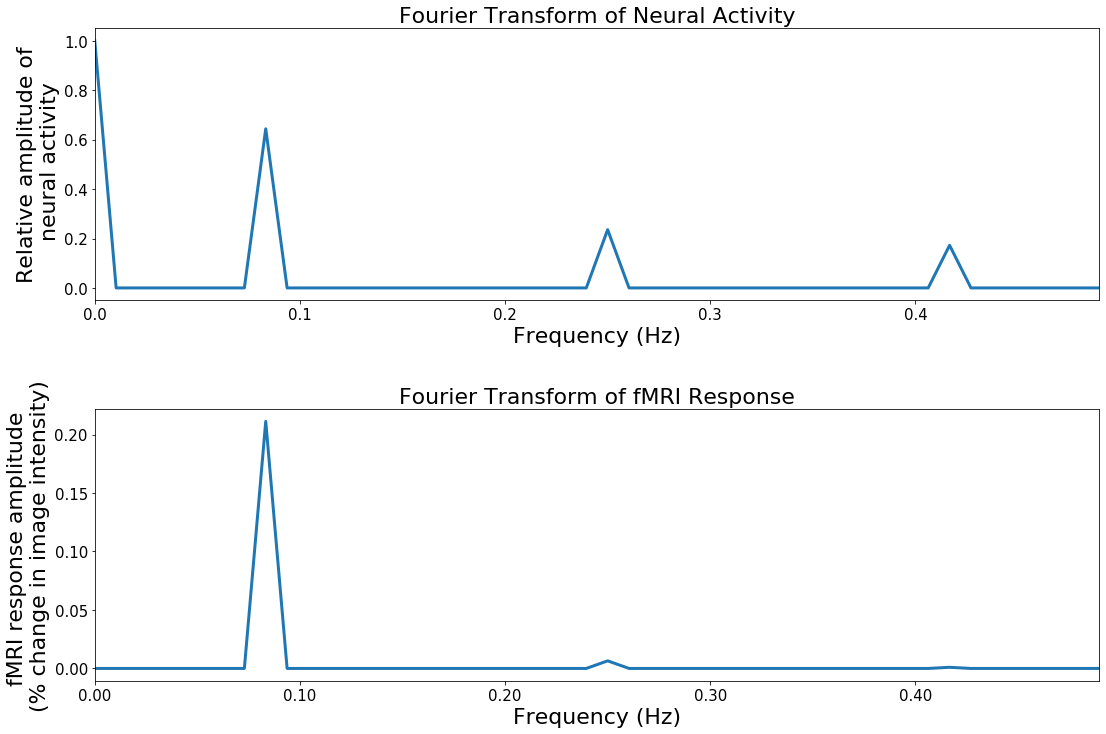

In [15]:
n_time = len(neural_activity)
neural_activity_fft = abs(sc.fft(neural_activity)) / (n_time/2)
fmri_response_fft = abs(sc.fft(fmri_response)) / (n_time/2)
neural_activity_fft = neural_activity_fft[:int(n_time/2)]
fmri_response_fft = fmri_response_fft[:int(n_time/2)]
frequencies = np.arange(0,(n_time/2))/n_time

# Plot it
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[18,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(frequencies, neural_activity_fft, lw=3)
ax1.set_xlim([0, frequencies[-1]])
ax1.set_xlabel('Frequency (Hz)', fontsize=22)
ax1.set_ylabel('Relative amplitude of\n neural activity', fontsize=22)
ax1.set_title('Fourier Transform of Neural Activity', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(frequencies, fmri_response_fft, lw=3)
ax2.set_xlim([0, frequencies[-1]])
ax2.set_xlabel('Frequency (Hz)', fontsize=22)
ax2.set_ylabel('fMRI response amplitude \n(% change in image intensity)', fontsize=22)
ax2.set_title('Fourier Transform of fMRI Response', fontsize=22)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.show()


The (n_time/2) is needed to scale the FFT properly. Note that the response amplitude plotted in figure 2 is about 0.2% change in image intensity, just what we got before.

Note that there are lots of frequency components in the block alternation of the stimulus and neural activity. But there is really only one component in the fMRI response. Why?

Try varying the 'block_duration' above to see what that does to the response amplitudes, to the transient in the fMRI responses, and to the frequency decomposition of the fMRI respones. What happens and why? It can be helpful to use block_durations that divide evenly into the overall duration (e.g., 6, 12, 24). Why?

### Noise

Go back and regenerate the block-alternation data with block_duration=6 (as you did originally before varying the block_duration).

Real data, of course, is noisy. We can simulate that too. The 'numpy.random.normal' function in Python produces normally distributed noise with a specified mean and variance. Let's make some noise with zero mean and a standard deviation of 0.1 and add it to the responses:

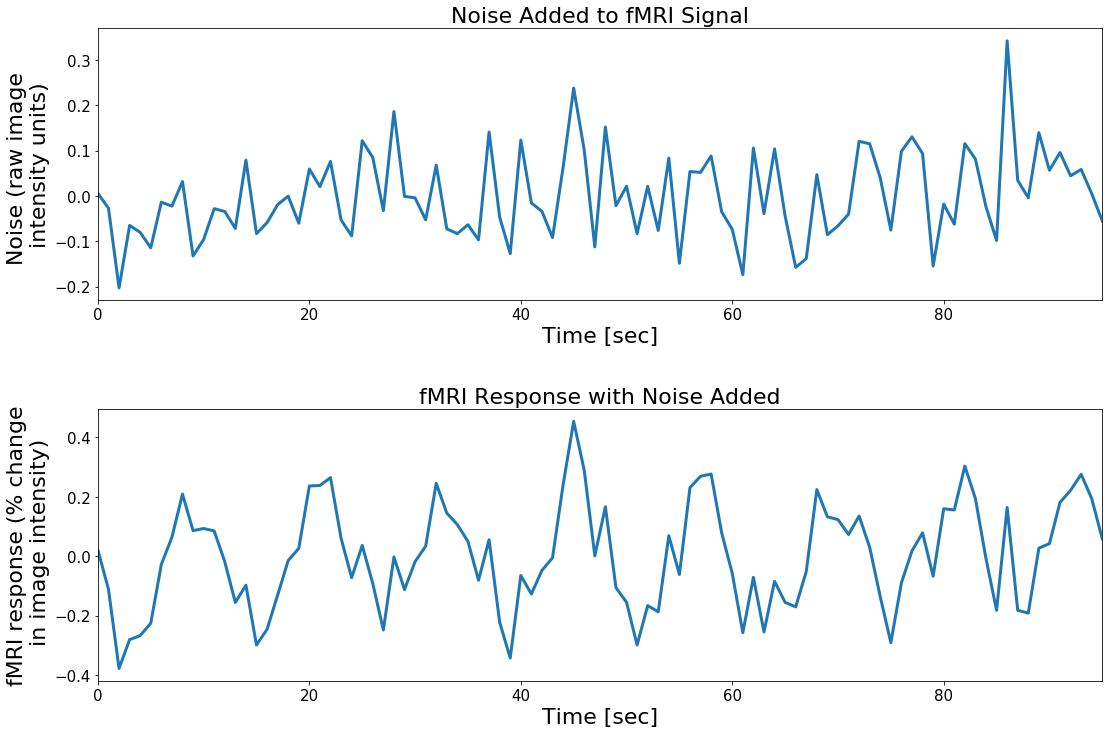

In [16]:
mu, noise_sd = 0, 0.1 # mean and standard deviation
noise = np.random.normal(mu, noise_sd, len(fmri_signal))
noisy_fmri_signal = fmri_signal + noise
fmri_response = 100 * ((noisy_fmri_signal/(np.mean(noisy_fmri_signal)) - 1))

# Plot it 
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[18,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(noise, lw=3)
ax1.set_xlim([0, len(noise)-1])
ax1.set_xlabel('Time [sec]', fontsize=22)
ax1.set_ylabel('Noise (raw image \nintensity units)', fontsize=22)
ax1.set_title('Noise Added to fMRI Signal', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(fmri_response, lw=3)
ax2.set_xlim([0, len(fmri_response)-1])
ax2.set_xlabel('Time [sec]', fontsize=22)
ax2.set_ylabel('fMRI response (% change\n in image intensity)', fontsize=22)
ax2.set_title('fMRI Response with Noise Added', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

Note that each time you evaluate the above code, you get a somewhat different result because of the noise.

### Drift

Real data also exhibits drift, that is largely caused by slow changes in the functioning of the MRI scanner. The drift is often modeled as being a linear drift, although that is not particularly accurate because sometimes it drifts up, sometimes down, and sometimes up and down. But we'll stick with the linear drift model for now.

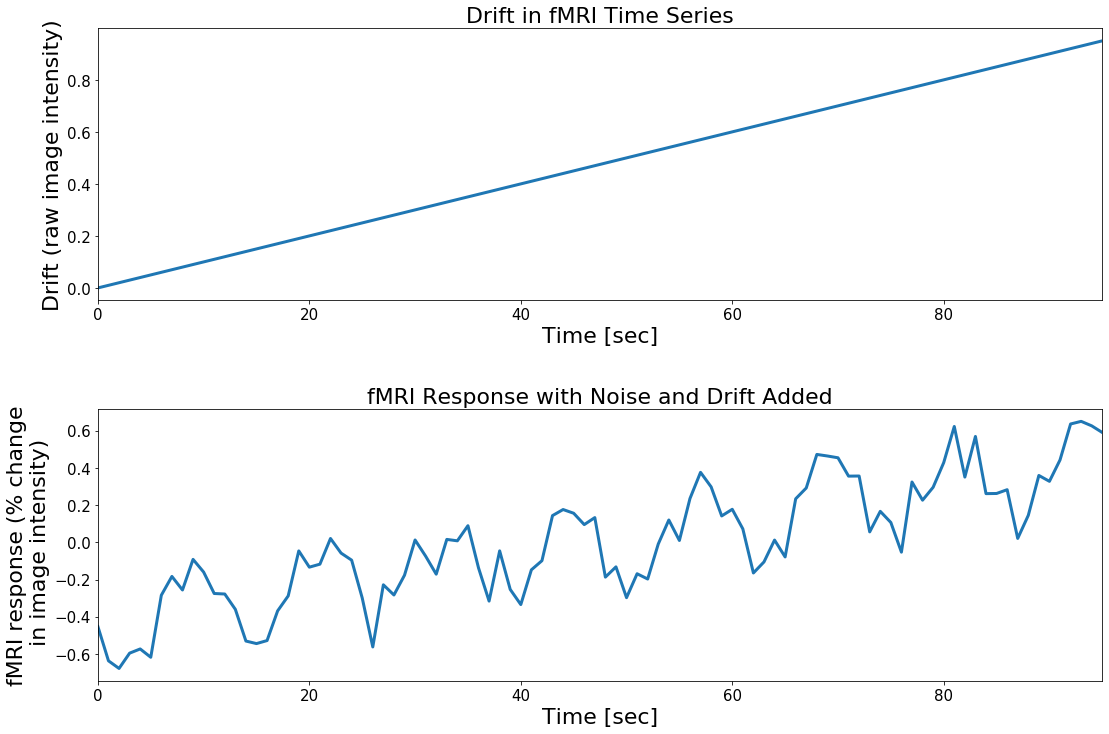

In [17]:
drift_rate = 0.01
mu, noise_sd = 0, 0.1 # mean and standard deviation
noise = np.random.normal(mu, noise_sd, len(fmri_signal))
drift = drift_rate * np.arange(0,len(fmri_signal))
noisy_fmri_signal = fmri_signal + noise + drift
fmri_response = 100 * ((noisy_fmri_signal/(np.mean(noisy_fmri_signal)) - 1))

# Plot it 
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[18,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(drift, lw=3)
ax1.set_xlim([0, len(drift)-1])
ax1.set_xlabel('Time [sec]', fontsize=22)
ax1.set_ylabel('Drift (raw image intensity)', fontsize=22)
ax1.set_title('Drift in fMRI Time Series', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(fmri_response, lw=3)
ax2.set_xlim([0, len(fmri_response)-1])
ax2.set_xlabel('Time [sec]', fontsize=22)
ax2.set_ylabel('fMRI response (% change\n in image intensity)', fontsize=22)
ax2.set_title('fMRI Response with Noise and Drift Added', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

Go back up above and compute the FFT of the new fMRI response (with noise and drift added). What does it look like now and why?

### Generating a whole pile of simulated data

To explore the statistics of fMRI data analysis, it is useful to generate a large number of simulated fMRI time series, one for each of a large number of simulated voxels. To keep things simple, the noise will be statistically independent and identically distributed. Half of the voxels will correspond to tissue that is activated by the block-alternation experimental protocol. The other half will not be active. 

Recompute the block alternation:

In [18]:
t = np.arange(0,120)
block_duration = 6
neural_activity = (t//block_duration + 1) % 2

fmri_signal = baseline + np.convolve(neural_activity,HIRF)
fmri_signal = fmri_signal[:len(neural_activity)]

Make a time series of "images", each with 2000 voxels, half of which will be activated and the other half not activated:

In [19]:
n_time = len(fmri_signal)

Fill nonactive voxels with baseline image intensity:

In [20]:
nonactive_voxels = baseline * np.ones([n_time,1000])

Fill active voxels, each with a copy of fmri_signal: 

In [21]:
active_voxels = np.transpose(np.matlib.repmat(fmri_signal,1000,1))

Put the two together, one above the other

In [22]:
data = np.concatenate((active_voxels,nonactive_voxels),axis=1)

The result is a 2d array: n_time_points x n_voxels

In [23]:
data.shape

(120, 2000)

Add noise and drift:

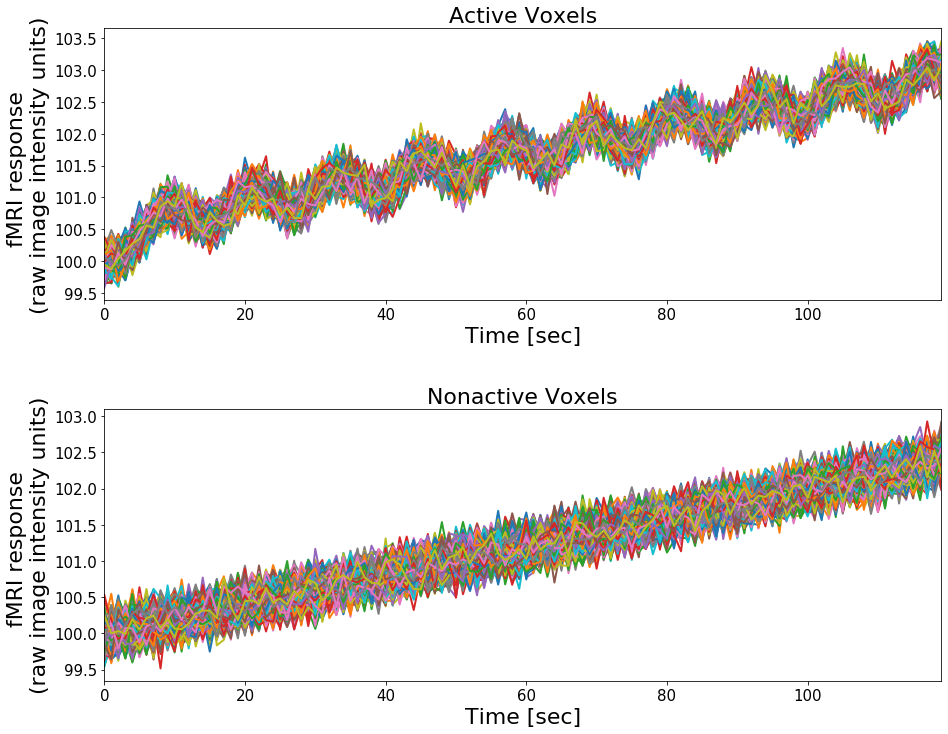

In [186]:
mu, noise_sd = 0, 0.1
drift_rate = 0.01

# Add noise
noise = np.random.normal(mu, noise_sd, data.shape)
data = data + noise;

# Add drift
for t in range(n_time):
    data[t,:] = data[t,:] + t*drift_rate
    
# Plot the time series for all of the active voxels and all of the inactive voxels:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[15,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(data[:,0:999], lw=2)
ax1.set_xlim([0, n_time-1])
ax1.set_xlabel('Time [sec]', fontsize=22)
ax1.set_ylabel('fMRI response \n(raw image intensity units)', fontsize=22)
ax1.set_title('Active Voxels', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(data[:,1000:1999], lw=2)
ax2.set_xlim([0, n_time-1])
ax2.set_xlabel('Time [sec]', fontsize=22)
ax2.set_ylabel('fMRI response \n(raw image intensity units)', fontsize=22)
ax2.set_title('Nonactive Voxels', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

## Introduction to fMRI data analysis

### Regression

Using linear regression (also called a general linear model or GLM) to estimate model parameters from the data.

We have a model for how the bold image intensities should change over time. The model, in fact, was used to generate the simulated data above. The model consists of: 1) the time course of the underlying neural activity, 2) the hemodynamic impulse response, 3) linear drift, 4) independent and identically distributed (Gaussian) noise. In a real data set, there are several unknown parameters in this model. The drift rate is unknown and may vary from one voxel to the next. This is not much of a problem (as we will see below) as long as it is actually a linear drift. But in reality it isn't a linear drift which is more of a problem. The parameters of the hemodynamic impulse response are unknown and they may vary from subject to subject, session to session, or even from one brain area to another. Most data analysis algorithms simply assume a fixed hemodynamic impulse response (which is almost certainly incorrect). The noise is even more of a problem. The noise, in reality, is neither independent (there are both spatial and temporal correlations in the noise) nor identically distributed (the noise variance can vary from one location to another). Most of the spiffy statistical techniques in fMRI data analysis have to do with the fact that the noise is not IID. But we will ignore these complications because the noise in our simulated data is IID and of known variance. Likewise, our hemodynamic impulse response function is also known. So we're in luck.

Linear regression (GLM) can always be written as a matrix multiplication:

$$
y = X b 
$$

where y is a vector of measurements, X is a matrix that consists of the model, and b are the unknown parameters of the model. The unknown parameters in b are sometimes referred to as "explanatory variables" because they are used to explain the variability in the data y. The values of b are sometimes referred to as "beta weights".

The basic idea is to regress the measured time series at a voxel against the model. This gives you estimates for the model's unknown parameters and it gives you a residual time series (the left over stuff that the model failed to account for). If the parameter estimate is large and the residuals are small relative to the noise variance, then your voxel is behaving as an "active" voxel should. If the both the parameter estimates and the residuals are small, then you are looking at a voxel that is not exhibiting activity. If the residuals are large, then you probably have a lousy model. 

In our case $y$ is the measured time series at a single voxel, a vector with 120 time points. The model in $X$ (often referred to as the design matrix because it has to do with the experimental design) is a matrix with 3 columns. The first column is the part of the model that accounts for the neural activity convolved with the HIRF. The second column is the part of the model that accounts for the linear drift, and the third column is the part of the model that accounts for the mean baseline image intensity. The vector $b$ contains the 3 parameters (beta weights) that we want to solve for. Parameter one estimates the amplitude of the underlying neural activity. Parameter two estimates the drift rate. Parameter 3 estimates the mean image intensity.

So all we need to do is build the 3 columns of $X$ and use regression to solve for $b$ at each voxel.

`Column 1`: model of activity. Here again we will compute our model for the fMRI signal, computed by convolving our model for the underlying neural activity with our model for the hemodynamic impulse response function:

In [25]:
model_activity = np.convolve(neural_activity,HIRF)
model_activity = model_activity[0:len(neural_activity)]

`Column 2`: linear drift.

In [26]:
model_drift = np.arange(0,n_time)

`Column 3`: constant, baseline image intensity.

In [27]:
model_constant = np.ones([n_time])

Build the design matrix by putting the 3 columns together:

In [28]:
model = np.transpose((np.stack((model_activity, model_drift, model_constant))))

Look at the model

In [29]:
model

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 2.00000000e+00, 1.00000000e+00],
       [3.79081662e-02, 3.00000000e+00, 1.00000000e+00],
       [1.29878027e-01, 4.00000000e+00, 1.00000000e+00],
       [2.55388742e-01, 5.00000000e+00, 1.00000000e+00],
       [3.90724025e-01, 6.00000000e+00, 1.00000000e+00],
       [5.18981835e-01, 7.00000000e+00, 1.00000000e+00],
       [6.31002739e-01, 8.00000000e+00, 1.00000000e+00],
       [6.85574060e-01, 9.00000000e+00, 1.00000000e+00],
       [6.66866755e-01, 1.00000000e+01, 1.00000000e+00],
       [5.97595335e-01, 1.10000000e+01, 1.00000000e+00],
       [5.04372220e-01, 1.20000000e+01, 1.00000000e+00],
       [4.07020619e-01, 1.30000000e+01, 1.00000000e+00],
       [3.17308485e-01, 1.40000000e+01, 1.00000000e+00],
       [2.78617241e-01, 1.50000000e+01, 1.00000000e+00],
       [3.08495099e-01, 1.60000000e+01, 1.00000000e+00],
       [3.85544268e-01, 1.70000

Now estimate $b$ (the beta weights). The equation is:

$$
y = X b
$$

where we want to solve for $b$. So we compute:

$$
b = pinv(X) * y
$$

where 'pinv' denotes the pseudo-inverse of a matrix. In Python, we estimate the pseudo-inverse using the `np.linalg.pinv` function.

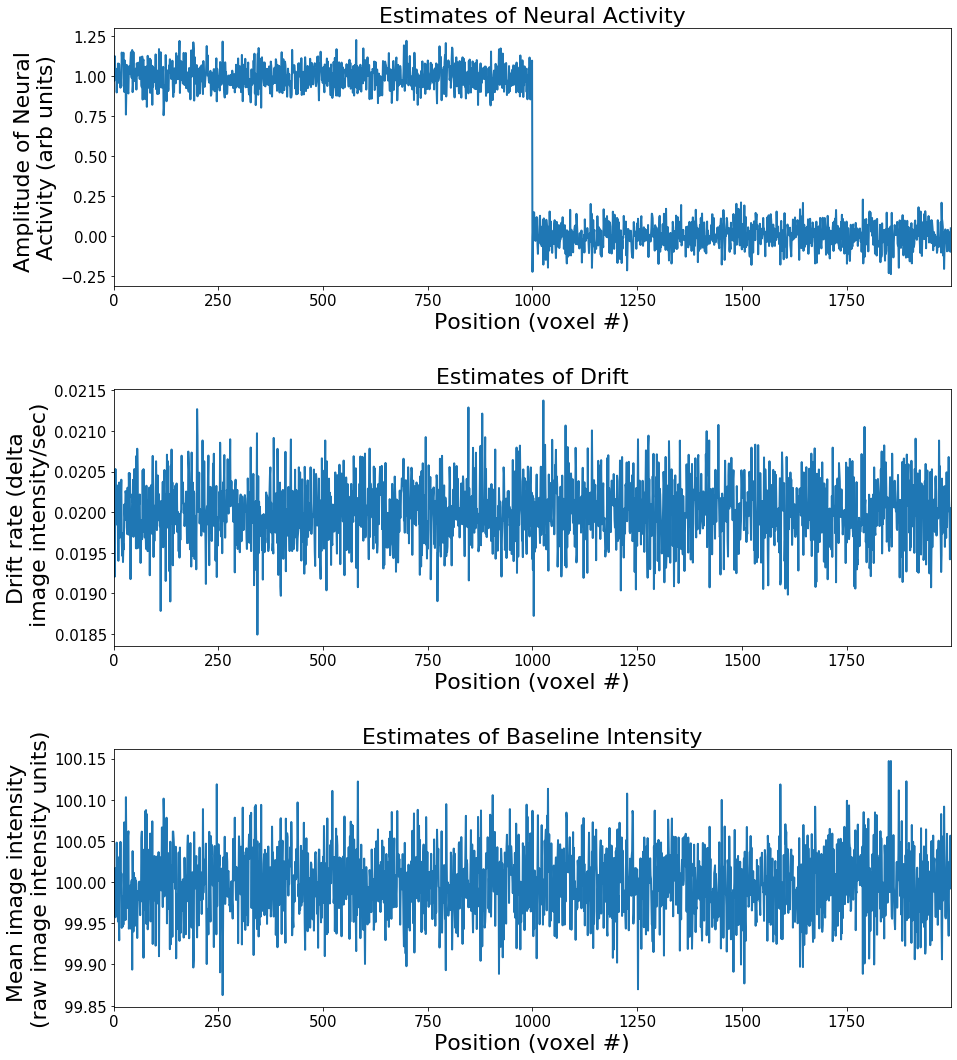

In [191]:
model_inv = np.linalg.pinv(model)

b = model_inv.dot(data)
n_voxels = data.shape[1]

# Plot the parameter estimates
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=[15,18])
fig.subplots_adjust(hspace=0.4)

ax1.plot(b[0,:], lw=2)
ax1.set_xlim([0, n_voxels-1])
ax1.set_xlabel('Position (voxel #)', fontsize=22)
ax1.set_ylabel('Amplitude of Neural \nActivity (arb units)', fontsize=22)
ax1.set_title('Estimates of Neural Activity', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(b[1,:], lw=2)
ax2.set_xlim([0, n_voxels-1])
ax2.set_xlabel('Position (voxel #)', fontsize=22)
ax2.set_ylabel('Drift rate (delta\n image intensity/sec)', fontsize=22)
ax2.set_title('Estimates of Drift', fontsize=22)
ax2.tick_params(labelsize=15)

ax3.plot(b[2,:], lw=2)
ax3.set_xlim([0, n_voxels-1])
ax3.set_xlabel('Position (voxel #)', fontsize=22)
ax3.set_ylabel('Mean image intensity \n(raw image intensity units)', fontsize=22)
ax3.set_title('Estimates of Baseline Intensity', fontsize=22)
ax3.tick_params(labelsize=15)
plt.show()

Note that the estimates of neural activity are around 1 for the active voxels and around 0 for the nonactive voxels. The estimated drift rates are all around 0.01. The mean image intensity estimates are all around 100. These are the values that were used above to generate the simulated data so we have succeeded in extracting reasonably good estimates for the parameters. 

### Putting error bars on the parameter estimates

Of course, it's not enough just to estimate the amplitudes of the underlying neural activity. Because the data are noisy, we need to put error bars on our measurements. One way to do this in Python is using the conf_int() method from StatsModels' RegressionResults:

https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.conf_int.html

In [192]:
b_min = np.zeros((3,n_voxels))
b_max = np.zeros((3,n_voxels))
for voxel in range(2000):
    mod = sm.OLS(data[:,voxel], model)
    res = mod.fit()
    b[:,voxel] = res.params   
    b_min[:,voxel] = res.conf_int(0.5)[:,0]
    b_max[:,voxel] = res.conf_int(0.5)[:,1]

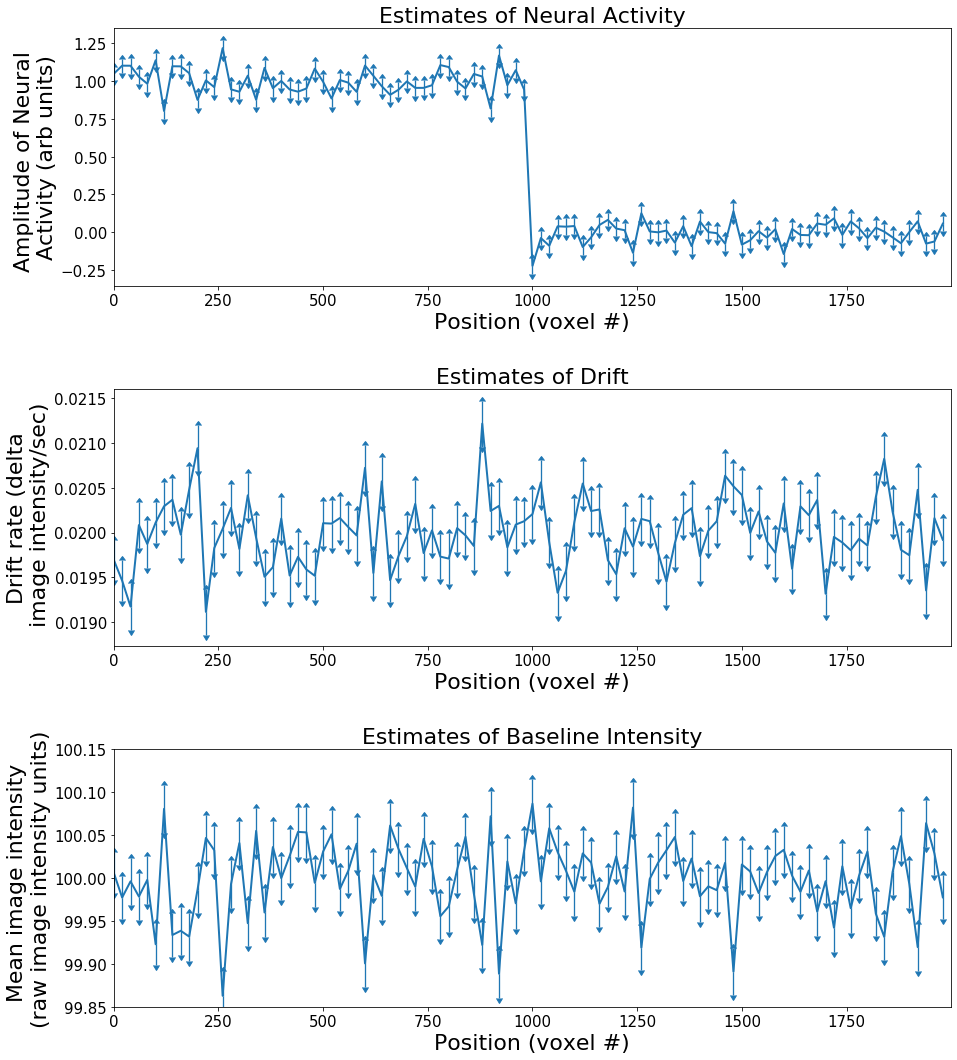

In [193]:
#Plot the parameter estimates (from every 20th voxel) with error bars
sub_vox = np.arange(0, n_voxels, 20)

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=[15,18])
fig.subplots_adjust(hspace=0.4)

ax1.errorbar(sub_vox, b[0,sub_vox], yerr = [b[0,sub_vox]-b_min[0,sub_vox], b_max[0,sub_vox]-b[0,sub_vox]], uplims=True, lolims=True,elinewidth=1.3, lw=2)
ax1.set_xlim([0, n_voxels-1])
ax1.set_xlabel('Position (voxel #)', fontsize=22)
ax1.set_ylabel('Amplitude of Neural \nActivity (arb units)', fontsize=22)
ax1.set_title('Estimates of Neural Activity', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.errorbar(sub_vox, b[1,sub_vox], yerr = [b[1,sub_vox]-b_min[1,sub_vox], b_max[1,sub_vox]-b[1,sub_vox]], uplims=True, lolims=True,elinewidth=1.3, lw=2)
ax2.set_xlim([0, n_voxels-1])
ax2.set_xlabel('Position (voxel #)', fontsize=22)
ax2.set_ylabel('Drift rate (delta\n image intensity/sec)', fontsize=22)
ax2.set_title('Estimates of Drift', fontsize=22)
ax2.tick_params(labelsize=15)

ax3.errorbar(sub_vox, b[2,sub_vox], yerr = [b[2,sub_vox]-b_min[2,sub_vox], b_max[2,sub_vox]-b[2,sub_vox]], uplims=True, lolims=True,elinewidth=1.3, lw=2)
ax3.set_xlim([0, n_voxels-1])
ax3.set_ylim([99.85, 100.15])
ax3.set_xlabel('Position (voxel #)', fontsize=22)
ax3.set_ylabel('Mean image intensity \n(raw image intensity units)', fontsize=22)
ax3.set_title('Estimates of Baseline Intensity', fontsize=22)
ax3.tick_params(labelsize=15)
plt.show()

For some (perhaps all) applications of fMRI, this is all that is really needed -  estimates for the amplitude of the underlying neural activity, ideally with error bars on the estimates. But for some reason, the neuroimaging field is obsessed with so-called statistical parameter maps...

## Statistical parameter maps

### Histograms of parameter estimates

Because error bars are difficult to visualize on a two-dimensional image, neuroimaging data analysis programs often create statistical-parameter maps that represent in one way or another whether or not the activity in each voxel is statistically significantly different between two or more conditions. This is, of course, equivalent to finding whether or not the error bars overlap.

The key statistical observation is that according to the null hypothesis (no activity), the parameter estimates are themselves normally distributed because they were computed using linear regression from data with IID normally distributed noise.

Plot histograms of first parameter estimate, the one that models neural activity:

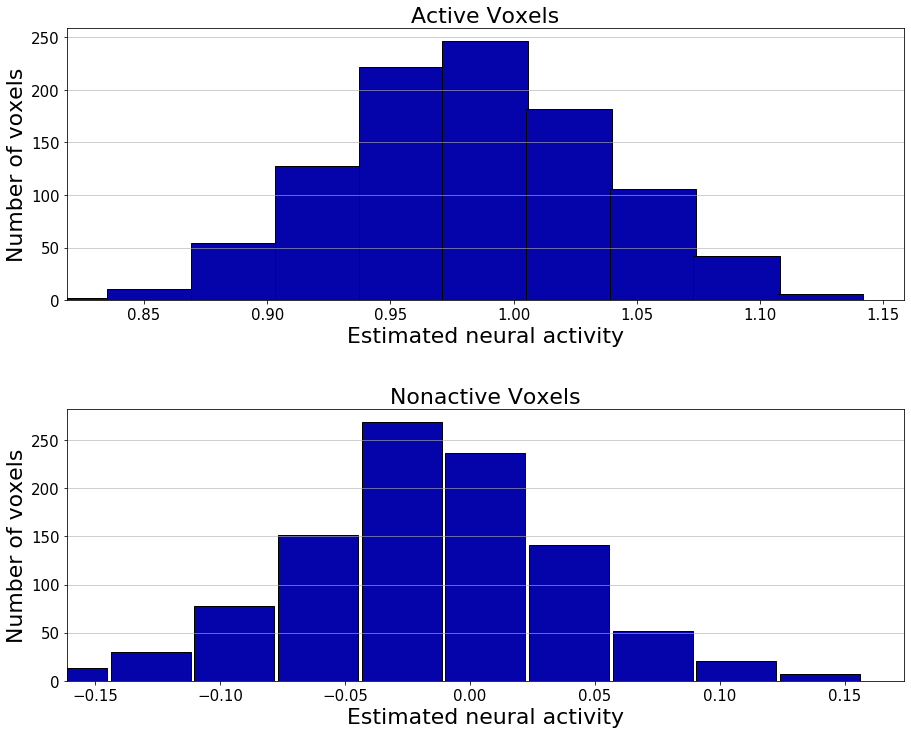

In [134]:
active_hist,active_bin_edges = np.histogram(b[0,0:999])
nonactive_hist,nonactive_bin_edges = np.histogram(b[0,1000:1999])

#Plot it
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[15,12])
fig.subplots_adjust(hspace=0.4)

ax1.bar(active_bin_edges[:-1], active_hist, width = 0.035, color='#0504aa', edgecolor='black')
ax1.set_xlim(min(active_bin_edges), max(active_bin_edges))
ax1.grid(axis='y', alpha=0.75)
ax1.set_xlabel('Estimated neural activity', fontsize=22)
ax1.set_ylabel('Number of voxels', fontsize=22)
ax1.set_title('Active Voxels', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.bar(nonactive_bin_edges[:-1], nonactive_hist, width = 0.032, color='#0504aa',edgecolor='black')
ax2.set_xlim(min(nonactive_bin_edges), max(nonactive_bin_edges))
ax2.grid(axis='y', alpha=0.75)
ax2.set_xlabel('Estimated neural activity', fontsize=22)
ax2.set_ylabel('Number of voxels', fontsize=22)
ax2.set_title('Nonactive Voxels', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

The two separate histograms, of course, correspond to the active voxels and the non-active voxels. The means of these two distributions are different from one another but we only know that because we knew which voxels to put in each plot separately. For a real data set, we won't know a priori which voxels are active or not. To determine if the parameter estimates are different from one another, or different from zero, we need to know their standard deviation. And that has to be estimated from the data.

### Residuals and noise estimation

If our model (neural activiy, hemodynamics, etc.) is accurate, then it should do a pretty good job of fitting the data. To find out how good the fit is, we can look at the residuals, that is, the difference between the observed data and the model fit at each voxel.

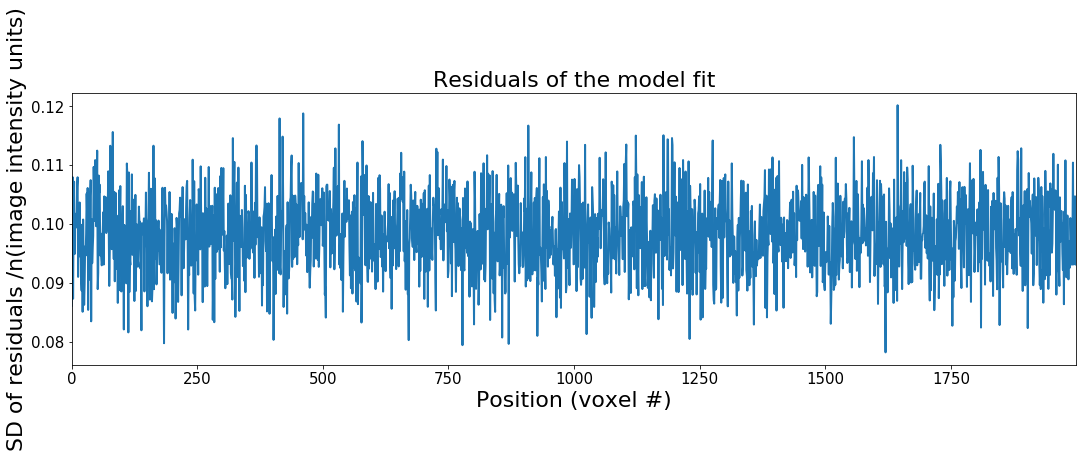

In [135]:
model_predictions = model.dot(b)
residuals = data - model_predictions

# Plot the SD of the residuals for each voxel:
plt.figure(figsize=(18,5))
plt.plot(np.std(residuals, axis = 0), lw=2)
plt.xlim([0, residuals.shape[1]-1])
plt.xlabel('Position (voxel #)', fontsize=22)
plt.ylabel('SD of residuals /n(image intensity units)', fontsize=22)
plt.title('Residuals of the model fit', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()

### Distribution of residuals

The residuals ought to be normally distributed. To check this, we scale the residuals by the noise standard deviation that was added in the first place:

In [136]:
residuals_z_score = residuals/noise_sd
residuals_z_score = np.reshape(residuals_z_score, np.prod(residuals_z_score.shape[:]))
n_samples = len(residuals_z_score)
step = 0.1

hist,bin_edges = np.histogram(residuals_z_score)
hist = hist / (step*n_samples)

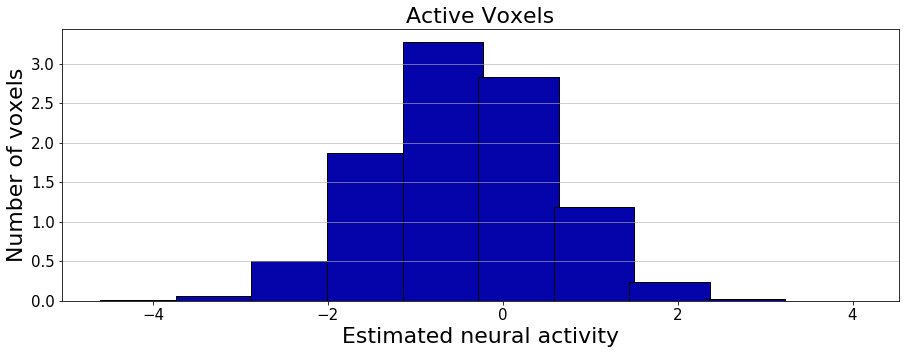

In [137]:
plt.figure(figsize=(15,5))
plt.bar(bin_edges[:-1], hist, width = 0.92, color='#0504aa', edgecolor = 'black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Estimated neural activity', fontsize=22)
plt.ylabel('Number of voxels', fontsize=22)
plt.title('Active Voxels', fontsize=22)
plt.tick_params(labelsize=15)

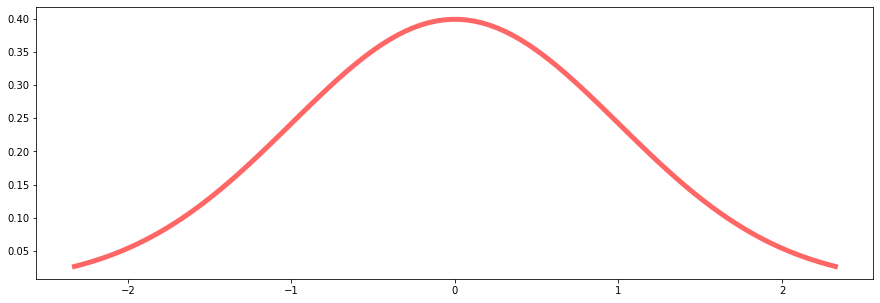

In [138]:
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

plt.figure(figsize=(15,5))
plt.plot(x, norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

And, as you can see, there is a very nice match between the normal pdf and the histogram of the residuals. 

Conclusion: the standard deviation of the residuals is a good estimate of the standard deviation of the noise.

### Transforming the noise estimates

The residuals tell us how good the fit is and inform us about the standard deviation of the noise in the data, but this is not what we really need to know. Rather, we need to know how good the parameter estimates are. Fortunately, this is pretty simple to characterize. The parameter estimates were computed as a weighted sum of the data. See above where we computed: 
$$
b = model\_inv * data
$$
Because the data are normally distributed and the parameter estimates are a weighted sum of the data, then the parameter estimates are also normally distributed. Phew. Now all we need is to figure out the standard deviation of the parameter estimates. The standard deviation of the parameter estimates can be computed from the standard deviations of the residuals by subjecting it to the same $model\_inv$ transformation.

Compute the standard deviation of the residuals, separately for each voxel:

In [139]:
residual_sd = np.std(residuals, axis=0)
residual_var = np.power(residual_sd,2)

Next we will transform the residual_sd to compute the standard deviation of the parameter estimates. We really care only about the 1st parameter that represents the amplitude of neural activity so that's the only one we'll compute. To pick this one (while ignoring the others) we define a 'contrast' vector:

In [140]:
c = np.zeros((3,1))
c[:,0] = [1,0,0]

Compute the parameter standard deviation for each voxel:

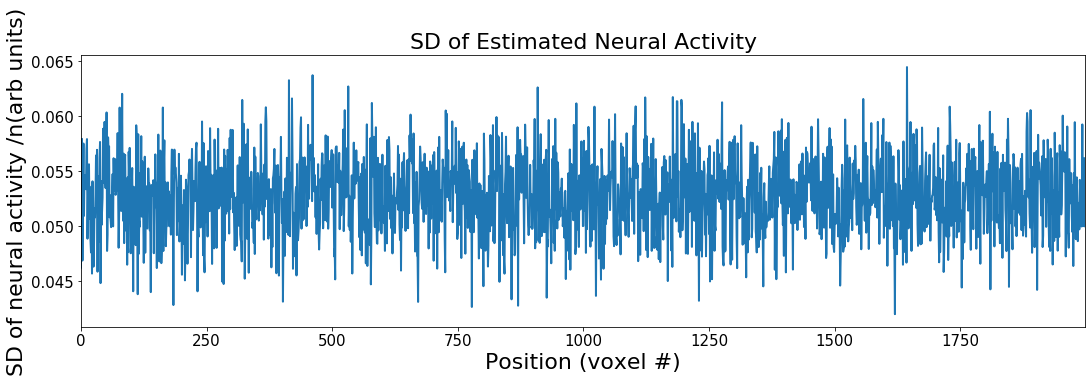

In [141]:
b_sd = np.zeros(residual_sd.shape)
n_voxels = len(residual_sd)

for voxel in range(n_voxels):
    b_sd[voxel] = np.sqrt(np.dot(np.dot(np.dot(np.dot(np.transpose(c),model_inv),np.transpose(model_inv)),c),residual_var[voxel]))
     
# Plot it
plt.figure(figsize=(18,5))
plt.plot(b_sd, lw=2)
plt.xlim([0, n_voxels-1])
plt.xlabel('Position (voxel #)', fontsize=22)
plt.ylabel('SD of neural activity /n(arb units)', fontsize=22)
plt.title('SD of Estimated Neural Activity', fontsize=22)
plt.tick_params(labelsize=15)
plt.show()

These estimates for the SDs are close to the sample standard deviations, computed separately for the active and non-active voxels:

In [142]:
print(np.mean(b_sd))
print(np.std(b[0,0:999]))
print(np.std(b[0,1000:1999]))

0.052793822803368515
0.05263505725707859
0.05362542676452196


The 3 numbers that get printed should be pretty close to one another. But note that we can compute the sample standard deviations from b only if we already know which voxels are active versus inactive, which is why we needed to do all the work computing bSD from the residuals.

Now we have everything we need and we can do a t-test for each voxel. The t statistic is the ratio of the parameter estimate to the estimated standard deviation. The p value is computed from the t statistic using the cumulative distribution function.

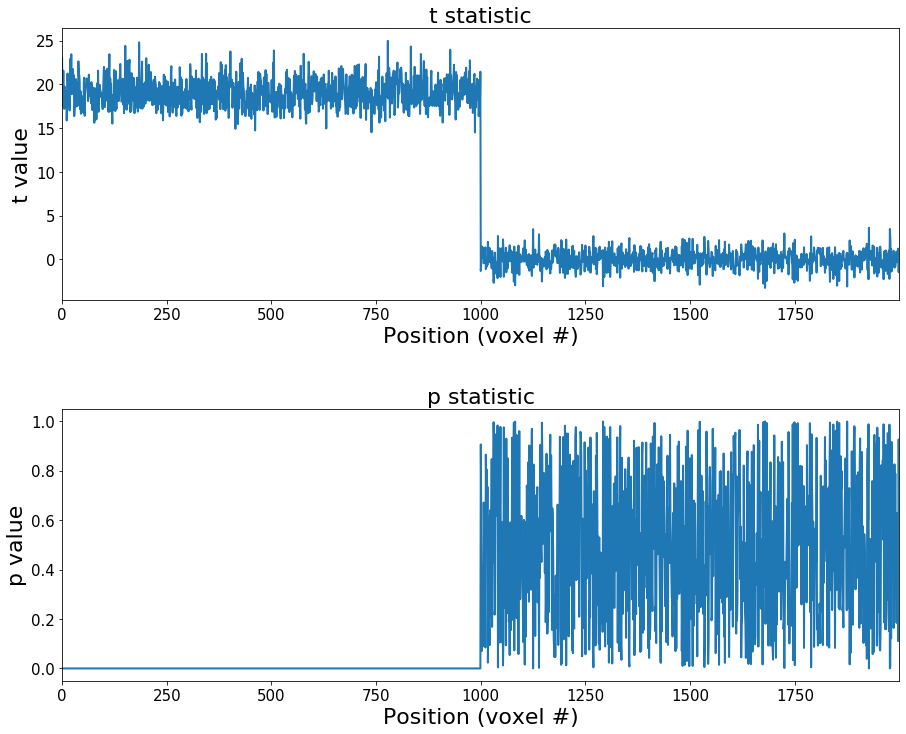

In [145]:
t_stat = b[0,:]/b_sd
p_value = t.sf(t_stat,117)

# Plot them
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[15,12])
fig.subplots_adjust(hspace=0.4)

ax1.plot(t_stat, lw=2)
ax1.set_xlim([0, n_voxels-1])
ax1.set_xlabel('Position (voxel #)', fontsize=22)
ax1.set_ylabel('t value', fontsize=22)
ax1.set_title('t statistic', fontsize=22)
ax1.tick_params(labelsize=15)

ax2.plot(p_value, lw=2)
ax2.set_xlim([0, n_voxels-1])
ax2.set_xlabel('Position (voxel #)', fontsize=22)
ax2.set_ylabel('p value', fontsize=22)
ax2.set_title('p statistic', fontsize=22)
ax2.tick_params(labelsize=15)
plt.show()

Count the number of "false alarms" among the pixels that are not active. There should be about 50 out of 1000 with p values < 0.05 and there should be about 10 with p values < 0.01.

In [146]:
print(np.sum(p_value[1000:1999]<0.05))
print(np.sum(p_value[1000:1999]<0.01))

49
12
